In [1]:
!screenfetch

                          ./+o+-       ivb@cds2
                  yyyyy- -yyyyyy+      OS: Ubuntu 18.04 bionic
               ://+//////-yyyyyyo      Kernel: x86_64 Linux 4.15.0-74-generic
           .++ .:/++++++/-.+sss/`      Uptime: 1d 2h 25m
         .:++o:  /++++++++/:--:/-      Packages: 3045
        o:+o+:++.`..```.-/oo+++++/     Shell: sh
       .:+o:+o/.          `+sssoo+/    CPU: Intel Xeon Gold 6154 @ 16x 3GHz
  .++/+:+oo+o:`             /sssooo.   GPU: Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB
 /+++//+:`oo+o               /::--:.   RAM: 16519MiB / 128933MiB
 \+/+o+++`o++o               ++////.  
  .++.o+++oo+:`             /dddhhh.  
       .+.o+oo:.          `oddhhhh+   
        \+.++o+o``-````.:ohdhhhhh+    
         `:o+++ `ohhhhhhhhyo++os:     
           .o:`.syhhhhhhh/.oo++o`     
               /osyyyyyyo++ooo+++/    
                   ````` +oo+++o\:    
                          `oo++.      


In [ ]:
# x -50 50
# y 0 50
# z 0 200

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import json
import config as C
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from utils import parse_camera_intrinsic as parse_camera_intrinsic
from scipy.spatial.transform import Rotation as R
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms as T
from torch import nn
from tqdm import tqdm

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
with open(C.TRAIN_CROPS_JSON, "r") as f:
    train_gt = json.load(f)

In [6]:
train_gt["annotations"][0]

{'id': 1,
 'image_id': 0,
 'category_id': 47,
 'bbox': [1723.0, 1776.0, 29.0, 26.0],
 'position': [3.8249, 31.7701, 168.57],
 'orientation': [0.0063812, -0.184722, 3.13912],
 'orientation_relative': [0.006918107352997232,
  -0.18451171371342667,
  3.139121365067781]}

In [7]:
p = parse_camera_intrinsic()
for k in p:
    p[k] = torch.from_numpy(np.array(p[k],dtype=np.float))

In [34]:
import io
class PKURegressionDataset(Dataset):
    
    def __init__(self, orientation_field, images_dir, max_size, transforms=None):
        super().__init__()
        self.orientation_field = orientation_field
        self.images_dir = images_dir
        self.max_size = max_size
        self.transforms = transforms
        
        with open(C.TRAIN_CROPS_JSON, "r") as f:
            self.gt = json.load(f)
        
        
        
                
        
        cat_ids = set(ann['category_id'] for ann in self.gt['annotations'])
        categories = [cat for cat in self.gt['categories'] if cat['id'] in cat_ids]
        self.category_id_to_label = {
            cat["id"]: label
            for label, cat in enumerate(sorted(categories, key=lambda x: x["id"]))
        }
        self.images_jpeg = self.load_images()
        
        self.p = parse_camera_intrinsic()
        for k in self.p:
            self.p[k] = float(self.p[k])
    
    def load_images(self):
        images = {}
        for image in tqdm(self.gt['images']):
            path = os.path.join(self.images_dir, image['file_name'])
            data = open(path, 'rb').read()
            images[image['id']] = io.BytesIO(data)
        return images
    
    def __len__(self):
        return len(self.gt["annotations"])
    
    def __getitem__(self, idx):
        image = self.load_image(idx)
        label = self.get_label(idx)
        bbox_x, bbox_y, bbox_w, bbox_h = self.get_bbox(idx)
        bbox_center_x, bbox_center_y = bbox_x + bbox_w / 2, bbox_y + bbox_h / 2
        wx, wy, wz = self.get_position(idx)
        orientation = self.get_orientation(idx)
        
        result =  dict(
            image=image,
            label=label,
            bbox=np.array([(bbox_center_x-self.p['cx'])/self.p['fx'], (bbox_center_y-self.p['cy'])/self.p['fy'], bbox_w/self.p['fx'], bbox_h/self.p['fy']]),
            position=np.array([wx, wy, wz]),
            distance=np.sqrt(wx**2 + wy**2 + wz**2),
            orientation=np.array(orientation)
            )
        if self.transforms is not None:
            result['image'] = self.transforms(result['image'])
        return result
    
    def load_image(self, idx):
        image_id = self.gt["annotations"][idx]["image_id"]
        image = self.decode_image(self.images_jpeg[image_id])
        w, h = image.size
        scale = self.max_size / max(w, h)
        w_new, h_new = int(w * scale), int(h * scale)
        image = image.resize((w_new, h_new), Image.LANCZOS)
        new_image = Image.new("RGB", (self.max_size, self.max_size))
        new_image.paste(image, ((self.max_size - w_new) // 2, (self.max_size - h_new) // 2))
        return new_image
        
    @staticmethod
    def decode_image(bytes_io):
        image = Image.open(bytes_io)
        image.load()
        return image
        
    def get_label(self, idx):
        return self.category_id_to_label[self.gt["annotations"][idx]["category_id"]]
    
    def get_bbox(self, idx):
        return self.gt["annotations"][idx]["bbox"]
    
    def get_position(self, idx):
        return self.gt["annotations"][idx]["position"]
    
    def get_orientation(self, idx):
        euler_angles = self.gt["annotations"][idx][self.orientation_field]
        rotation = R.from_euler("YXZ", euler_angles)
        q = rotation.as_quat()
        e = np.array([0,0,1])
        q[:3] = q[:3] * np.dot(e, q[:3]) / (np.abs(np.dot(q[:3], e)))
        return q

In [35]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [36]:
ds = PKURegressionDataset("orientation", C.TRAIN_CROPS_ORIGIN, 256, transforms)


100%|██████████| 49115/49115 [00:01<00:00, 46368.37it/s]

In [37]:
len(ds)

49115

In [12]:
r = ds[3]

In [13]:
r["image"].shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


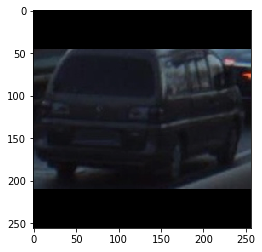

In [14]:
plt.imshow((np.transpose(r["image"].numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])))

In [15]:
r

{'image': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044,

In [16]:
dl = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True, pin_memory=True)

In [17]:
for batch in dl:
    break

print(batch)

In [18]:
len(ds.category_id_to_label)

34

In [19]:
batch['image'].shape

torch.Size([64, 3, 256, 256])

In [20]:
class ConvBnAct(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(inplace=True)
        
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        nn.init.constant_(self.conv.bias, 0)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet101(pretrained=True)
        
        self.local_neck = nn.Sequential(
            ConvBnAct(2048, 512),
            ConvBnAct(512, 256),
            ConvBnAct(256, 64),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 1024),  # 4
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 1024),  # 6
            nn.LeakyReLU(inplace=True)
        )
        nn.init.kaiming_normal_(self.local_neck[4].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.local_neck[4].bias, 0)
        nn.init.kaiming_normal_(self.local_neck[6].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.local_neck[6].bias, 0)
        
        self.cls_head = nn.Linear(1024, 34)
        nn.init.kaiming_normal_(self.cls_head.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.cls_head.bias, 0)
        
        self.rot_head = nn.Linear(1024, 4)
        nn.init.kaiming_normal_(self.rot_head.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.rot_head.bias, 0)
        
        self.trans_ass = nn.Sequential(
            nn.Linear(2,128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128,128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128,128),
            nn.LeakyReLU(inplace=True)
        )
        nn.init.kaiming_normal_(self.trans_ass[0].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_ass[0].bias, 0)
        nn.init.kaiming_normal_(self.trans_ass[2].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_ass[2].bias, 0)
        nn.init.kaiming_normal_(self.trans_ass[4].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_ass[0].bias, 0)
        
        self.trans_neck = nn.Sequential(
             nn.Linear(1024, 128),  # 0
             nn.LeakyReLU(inplace=True)#,
#             nn.Linear(100, 100),  # 2
#             nn.LeakyReLU(inplace=True),
        )
        nn.init.kaiming_normal_(self.trans_neck[0].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_neck[0].bias, 0)
#         nn.init.kaiming_normal_(self.trans_neck[2].weight, nonlinearity='leaky_relu')
#         nn.init.constant_(self.trans_neck[2].bias, 0)
        
#         self.ln_to_trans = nn.Sequential(
#             nn.Linear(1024, 100),  # 0
#             nn.LeakyReLU(inplace=True)
#         )
#         nn.init.kaiming_normal_(self.ln_to_trans[0].weight, nonlinearity='leaky_relu')
#         nn.init.constant_(self.ln_to_trans[0].bias, 0)
        self.size_neck = nn.Linear(2,128)
        nn.init.xavier_normal_(self.size_neck.weight)
        nn.init.constant_(self.size_neck.bias, 0)
    
        self.trans_head = nn.Linear(128, 1)
        nn.init.xavier_normal_(self.trans_head.weight)
        nn.init.constant_(self.trans_head.bias, 0)
        
    def extract_features(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        return x
    
    def forward(self, x,bbox):
        features = self.extract_features(x)
        ln = self.local_neck(features)
        tn = self.trans_neck(ln)
        ta = self.trans_ass(bbox[:,:2])
#         translation_v1 = self.trans_neck(bbox)
#         ln_to_trans_n = self.ln_to_trans(ln)
#         #rint((translation_v1.shape,ln_to_trans_n.shape))
        
        sn = self.size_neck(bbox[:,2:])
        
        translation = self.trans_head(sn*tn*ta)
        cls_score = self.cls_head(ln)
        orientation = self.rot_head(ln)
        
        return dict(cls_score=cls_score, orientation = orientation, distance = translation)

In [21]:
model = Model()

In [22]:
#sum(p.nelement() for p in model.parameters())

In [23]:
#sum(p.nelement() for p in model.backbone.parameters())

outputs = model(batch['image'])

outputs

 torch.norm(outputs['orientation'], dim=-1, keepdim=True)

In [24]:
def huber_loss(bbox_pred, bbox_targets, beta=2.8):
    """
    SmoothL1(x) = 0.5 * x^2 / beta      if |x| < beta
                  |x| - 0.5 * beta      otherwise.
    https://en.wikipedia.org/wiki/Huber_loss
    """
    box_diff = bbox_pred - bbox_targets

    dis_trans = torch.norm(box_diff, dim=1)
    # dis_trans = np.linalg.norm(box_diff.data.cpu().numpy(), axis=1)
    # we also add a metric for dist<2.8 metres.
    inbox_idx = dis_trans <= 2.8
    outbox_idx = dis_trans > 2.8

    # bbox_inside_weights = torch.from_numpy(inbox_idx.astype('float32')).cuda()
    # bbox_outside_weights = torch.from_numpy(outbox_idx.astype('float32')).cuda()
    bbox_inside_weights = inbox_idx.float()
    bbox_outside_weights = outbox_idx.float()

    in_box_pow_diff = 0.5 * torch.pow(box_diff, 2) / beta
    in_box_loss = in_box_pow_diff.sum(dim=1) * bbox_inside_weights

    out_box_abs_diff = torch.abs(box_diff)
    out_box_loss = (out_box_abs_diff.sum(dim=1) - beta / 2) * bbox_outside_weights

    loss_box = in_box_loss + out_box_loss
    N = loss_box.size(0)  # batch size
    loss_box = loss_box.view(-1).sum(0) / N
    return loss_box

In [25]:
def dist_to_coord(outputs, batch):
#     print(outputs['distance'])
    z_outputs = outputs['distance']*torch.sqrt(1/torch.reshape(1+torch.pow(batch['bbox'][:,0],2)+torch.pow(batch['bbox'][:,1],2),(64,1)))
    x_outputs = torch.reshape(batch['bbox'][:,0],(64,1))*z_outputs
    y_outputs = torch.reshape(batch['bbox'][:,1],(64,1))*z_outputs
#     print(torch.cat((x_outputs,y_outputs,z_outputs),dim = -1))
    return torch.cat((x_outputs,y_outputs,z_outputs),dim = -1)

def dist_to_coord(outputs, batch):
#     print(outputs['distance'])
    z_outputs = outputs['distance']*torch.sqrt(1/torch.reshape(1+torch.pow((batch['bbox'][:,0]-p['cx'])/p['fx'],2)+torch.pow((batch['bbox'][:,1]-p['cy'])/p['fy'],2),(64,1)))
    x_outputs = torch.reshape((batch['bbox'][:,0]-p['cx'])/p['fx'],(64,1))*z_outputs
    y_outputs = torch.reshape((batch['bbox'][:,1]-p['cy'])/p['fy'],(64,1))*z_outputs
#     print(torch.cat((x_outputs,y_outputs,z_outputs),dim = -1))
    return torch.cat((x_outputs,y_outputs,z_outputs),dim = -1)

In [26]:
def loss_fn(outputs, batch):
    cls_loss = nn.functional.cross_entropy(outputs['cls_score'], batch['label'])
    normed = outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True)
    
#     e = torch.FloatTensor([0, 0, 1]).cuda()
#     prod = (normed[:, :3] * e).sum(dim=1)
#     normed2 = torch.cat((torch.unsqueeze(prod / torch.abs(prod), 1) * normed[:, :3], normed[:, 3:4]), dim=1)
#     trans_loss = huber_loss(outputs['translation'],batch['position'])

    rot_loss_old = nn.functional.l1_loss(normed, batch['orientation'])
    
    rot_loss = 1-(normed[:, -1] * batch['orientation'][:, -1] + \
               (normed[:, :-1] * batch['orientation'][:, :-1]).sum(dim=1)).mean()
    trans_loss = huber_loss(dist_to_coord(outputs,batch),batch['position'])
#     distance_loss = huber_loss(outputs['distance'],batch['distance'])
    
    loss =  rot_loss + 0.1*trans_loss + cls_loss 
    return dict(loss=loss, cls_loss=rot_loss_old, rot_loss = rot_loss, trans_loss = trans_loss)

In [27]:
model = model.cuda()

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

sd = optimizer.state_dict()
sd['param_groups'][0]['lr'] = sd['param_groups'][0]['lr']/2
optimizer.load_state_dict(sd)

sd['param_groups'][0]['lr']

In [29]:
losses = []

In [30]:
pbar = tqdm(total=len(dl))

  0%|          | 0/767 [00:00<?, ?it/s]

In [31]:
def smooth(beta, array):
    s=[]
    s.append(array[0])
    for i in range(1,len(array)):
        s.append((1-beta)*s[-1]+beta*array[i])
    return s

In [32]:
#pbar = tqdm(total=len(dl))
for i in range(100):
    for batch in dl:
        for k in batch:
            if k == 'label':
                batch[k] = batch[k].long()
            else:
                batch[k] = batch[k].float()
            batch[k] = batch[k].cuda()
        outputs = model(batch['image'],batch['bbox'])
        loss = loss_fn(outputs, batch)
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
        for k in loss:
            loss[k] = loss[k].item()
        losses.append(loss)
        pbar.update()
        pbar.set_description("{:.5f} {:.5f} {:.5f} {:.5f} ".format(loss['loss'], loss['cls_loss'], loss['rot_loss'], loss['trans_loss']))
    sd = optimizer.state_dict()
    sd['param_groups'][0]['lr'] = sd['param_groups'][0]['lr']/2
    optimizer.load_state_dict(sd)

0.53049 0.10349 0.08995 1.81559 : : 76700it [14:24:52,  1.23it/s]                     

model.load_state_dict(torch.load("stupid_1501_model.pth"))

In [36]:
%autoreload 0

In [37]:
# torch.save(model.state_dict(), "model_16-01-11:11.pth") 
# torch.save(optimizer.state_dict(), "optim_16-01-11:11.pth")

In [29]:
model.load_state_dict(torch.load("model_16-01-11:11.pth"))

<All keys matched successfully>

In [30]:
pbar = tqdm(total=len(dl))
s = 0
for batch in dl:
    for k in batch:
        if k == 'label':
            batch[k] = batch[k].long()
        else:
            batch[k] = batch[k].float()
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(batch['image'],batch['bbox'])
    dis_trans = torch.norm(batch['position'] - dist_to_coord(outputs,batch), dim=1)
    s += (dis_trans < 0.1).long().sum().item()
    pbar.update()
print(s / len(ds))

100%|██████████| 767/767 [04:27<00:00,  2.62it/s]

0.012562353659778073


In [31]:
print(s)

617


torch.save(model.state_dict(), "stupid_1501_model.pth")
torch.save(optimizer.state_dict(), "stupid_1501_optim.pth")

In [32]:
plt.plot([l["cls_loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
plt.plot(smooth(0.1, [l["cls_loss"] for l in losses]))
plt.ylim((0,0.5))
plt.grid()

NameError: name 'losses' is not defined

In [ ]:
# lr = 0.0001
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim(0,30)
plt.grid()

In [33]:
# lr = 0.001
plt.plot([l["loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["loss"] for l in losses]))
plt.ylim((0,7))
plt.grid()

NameError: name 'losses' is not defined

# lr = 0.001, LeakyReLU
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, ReLU, xavier_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, ReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,0.1))
plt.grid()

# lr = 1E-6, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,0.1))
plt.grid()

torch.save(model.state_dict(), "scare_model.pth")
torch.save(optimizer.state_dict(), "scare_optim.pth")

batch['orientation']

outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True)

torch.sum(torch.abs(outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True) - batch['orientation']), dim=1)

torch.sum((outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True) - batch['orientation']) ** 2, dim=1) ** 0.5

batch['label']

torch.argmax(outputs['cls_score'], dim=1)

model.backbone

nn.Sequential

import pandas as pd

df = pd.read_csv(C.TRAIN_CSV)

df.head()

import utils

train_anns = utils.load_train_annotations()

train_anns["ID_8a6e65317"]

orientations_euler = []
for k, v in train_anns.items():
    for y, p, r in zip(v["yaws"], v["pitches"], v["rolls"]):
        orientations_euler.append((-p, -y, -r))

len(orientations_euler)

from scipy.spatial.transform import rotation as R

euler_angles = self.gt["annotations"][idx][self.orientation_field]
rotation = R.from_euler("XYZ", euler_angles)
q = rotation.as_quat()

def quaternion_to_euler_angle(q):

    """Convert quaternion to euler angel.
    Input:
        q: 1 * 4 vector,
    Output:
        angle: 1 x 3 vector, each row is [roll, pitch, yaw]
    """
    w, x, y, z = q
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def euler_angles_to_quaternions(angle):
    """Convert euler angels to quaternions representation.
    Input:
        angle: n x 3 matrix, each row is [roll, pitch, yaw]
    Output:
        q: n x 4 matrix, each row is corresponding quaternion.
    """

    in_dim = np.ndim(angle)
    if in_dim == 1:
        angle = angle[None, :]

    n = angle.shape[0]
    roll, pitch, yaw = angle[:, 0], angle[:, 1], angle[:, 2]
    q = np.zeros((n, 4))

    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)

    q[:, 0] = cy * cr * cp + sy * sr * sp
    q[:, 1] = cy * sr * cp - sy * cr * sp
    q[:, 2] = cy * cr * sp + sy * sr * cp
    q[:, 3] = sy * cr * cp - cy * sr * sp

    return q

orientations_euler = np.array(orientations_euler)

orientations_quat = euler_angles_to_quaternions(orientations_euler[:, ::-1])

orientations_quat[:30]

for q in orientations_quat[:100]:
    print(q)

orientations_quat[0]

((orientations_quat[2][1:] / np.sin(np.arccos(orientations_quat[2][0]))) ** 2).sum()

((orientations_quat[2][:-1] / np.sin(np.arccos(orientations_quat[2][-1]))) ** 2).sum()